### 소개

이 노트북은 기본 학습 모델 중 앙상블에 대해 매우 기본적이고 간단한 입문서이다. 특히 앙상블의 변종인 Stacking도 다룬다. **간단히 말해서 stacking은 첫 번째 단계에서 기본적인 분류기로 예측을 사용한 다음 두 번째 단계에서 모델링을 할 때 첫 번째 단계에서 예측한 값을 포함해 예측을 진행한다.**

Titanic 데이터는 Kaggle의 많은 신인들이 이곳에서 시작해 이 개념을 이용할 수 있는 가장 좋은 데이터라고 볼 수 있다. 또한 Stacking이 Kaggle에서 우승하는데 많은 기여를 했지만 주제에 대한 커널이 많이 부족하다. 그래서 이 노트북을 통해 부족한 것을 채우길 바란다. 

In [1]:
# Load in our libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# stacking에 쓰일 5가지 기본적인 모델
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

### Feature Exploration, Engineering and Cleaning

이제 대부분의 커널이 전처리하는 방식과 비슷하게 진행할 것이다. 먼저 데이터를 탐색하고 가능한 feature를 식별하고 범주형 feature를 숫자로 인코딩하는 것이다.

In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


#### Feature Engineering

[참고 링크 by Sina](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)

In [3]:
full_data = [train, test]

# 추가한 feature
# 이름의 길이
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabin 값 유무
train['Has_Cabin'] = train['Cabin'].apply(lambda x : 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x : 0 if type(x) == float else 1)


# Sina의 노트를 참고한 feature engineering
# SibSp와 Parch의 조합으로 FamilySize feature을 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# FamilySize에서 새로운 Isalone feature 생성
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Remove all NULLS in the Fare column and create a new feature CateoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

# Group all nun-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test = test.drop(drop_elements, axis = 1)

이제 feature 전처리를 통해 모든 feature를 수치형으로 바꿨으며 모델 학습에 적용 가능하게 되었다. 그러나 간단한 상관 관계 및 분포를 확인해야 한다.

### Visualisations

In [5]:
train.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3


#### Pearson Correlation Heatmap

feature의 상관 관계 그림을 통해 각 feature별 어떤 관련이 있는지 확인해야 한다. 이를 위해 Seaborn Plotting Package를 활용하여 다음과 같이 매우 편리하게 Heatmap을 그릴 수 있다.

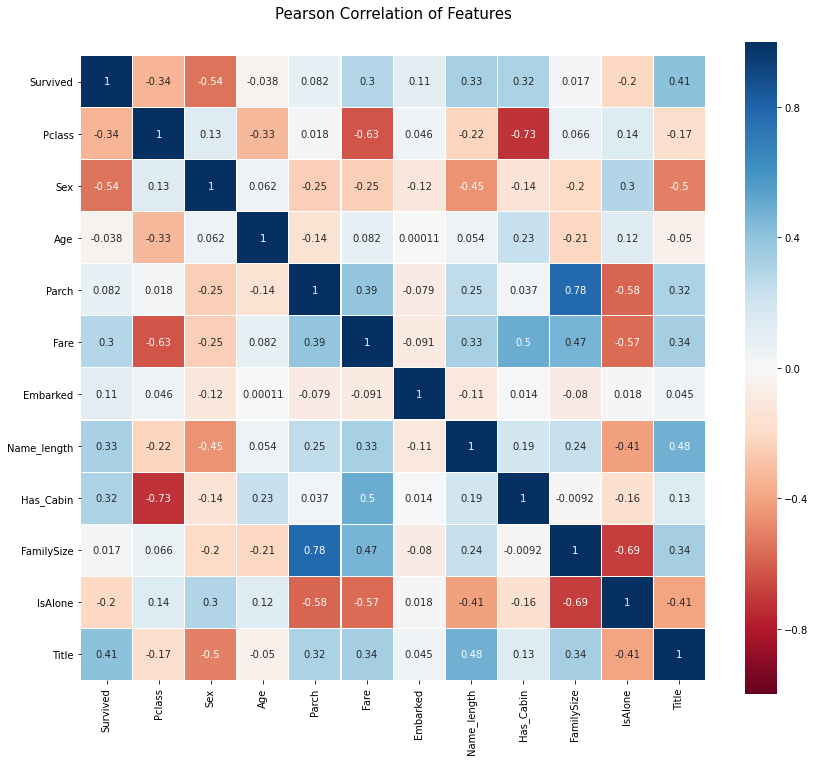

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax = 1, vmin = -1,
           square = True, cmap = colormap, linecolor='white', annot = True)

Pearson 상관관계그림을 통해 알 수 있는 한 가지 사실은 서로 강하게 상관되는 특징이 그리 많지 않다는 것이다. 이는 train set에 중복되거나 불필요한 데이터가 많지 않다는 것을 의미하기 때문에 모델 학습할 때 유용하다고 볼 수 있다.

#### Pairplots

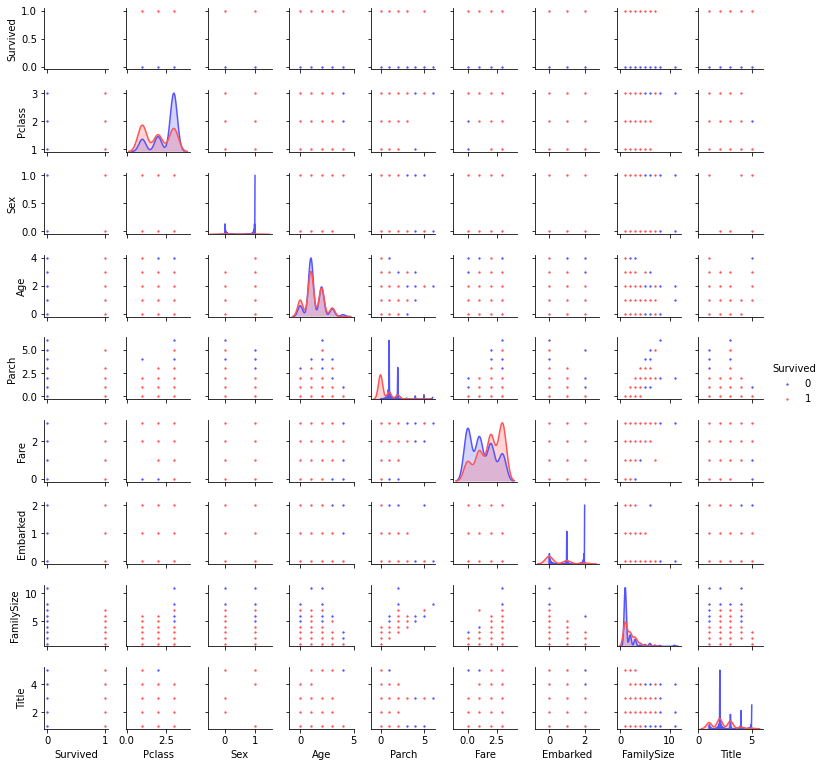

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex',
                        u'Age', u'Parch', u'Fare',
                        u'Embarked',u'FamilySize', u'Title']],
                hue = 'Survived', palette='seismic',
                size = 1.2, diag_kind='kde',
                diag_kws = dict(shade = True),
                plot_kws = dict(s=10))

### Ensembling & Stacking models

#### Helpers via Python Classes
여기서 우리는 파이썬 클래스를 사용하여 더 편리하도록 도와준다. 프로그래밍을 처음 접하는 사람들은 일반적으로 객체 지향 프로그래밍과 함께 사용되는 클래스를 듣게 된다. 간단하게 말하면 클래스는 객체를 만들기 위한 코드/프로그램을 확장해 특정한 기능과 방법을 구현한 것이다. 

In [8]:
# 나중에 유용하게 사용할 수 있는 parameter
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits= NFOLDS,random_state=SEED)

# Class to extend the SKlearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x,y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

기본 분류기를 만들 때 Sklearn 라이브러리에만 있는 모델만 사용하고 이에 대한 클래스만 확장한다. 위 클래스는 분류기를 만들어주고 clf(원하는 분류기), seed, parameters(매개 변수)라는 변수들이 필요하다. Class 내의 함수들은 단순히 sklearn 분류기에 이미 존재하는 해당 함수를 호출하는 함수이다. 기본적으로 다양한 SKlearn 분류기를 확장하기 위해 wrapper 클래스를 만들어 동일한 코드를 반복해서 써야 하는 것을 줄일 수 있도록 했다.

### Out-of-Fold Predictions

**`Stacking`은 기본 분류 모델의 예측값을 최종 모델 학습을 위해 사용하는 것이다.** 그러나 전체 훈련 데이터에서 먼저 모델을 훈련시키고 전체 테스트 세트에 대한 예측을 생성한 값을 최종 훈련에 쓸 수 없다. 이렇게 하면 이미 test set에 대한 정보가 들어갔기 때문에 test에 과적합 될 수 있다.

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest)) # np.empty : 무작위 값 대입
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1, 1)

### 기본 모델 생성

5가지 모델을 기본 분류로 준비한다. 이들은 sklearn에서 편하게 호출 가능하며 다음과 같다.

- **1) Random Forest**
- **2) Extra Trees**
- **3) AdaBoost**
- **4) Gradient Boosting**
- **5) Support Cector Machine**

#### Parameters

- **n_jobs** : 학습에 사용되는 코어 갯수, -1로 설정할 경우 모든 코어가 사용된다.
- **n_estimators** : tree의 수 설정(기본값은 10개)
- **max_depth** : 트리의 최대 깊이. 값을 높게 설정할 경우 과적합 위헙이 있어 주의해야 한다.
- **verbose** : 학습 프로세스 중 진행 상황을 출력할지 여부를 제어. 값이 0일 때는 모든 텍스트가 제어되고 값이 3일 때는 출력이 된다.

In [10]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [11]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [12]:
y_train = train['Survived'].ravel() # dataframe to numpy array
train = train.drop(['Survived'], axis = 1)
x_train = train.values
x_test = test.values

(x_train.shape, x_test.shape, y_train.shape)

((891, 11), (418, 11), (891,))

In [13]:
# OOF train 생성 후 test 예측. 이 결과는 새로운 feature로 사용이 된다.
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

### 분류기별 feature 중요도 확인

In [14]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

[0.12446239 0.20079006 0.03229203 0.02169732 0.07266097 0.0230757
 0.10876634 0.06443507 0.06715488 0.01386968 0.27079556]
[0.11808432 0.37797508 0.02859091 0.01695676 0.05652157 0.0280481
 0.04813956 0.08411001 0.04532444 0.021082   0.17516726]
[0.03  0.012 0.012 0.062 0.04  0.01  0.696 0.014 0.052 0.004 0.068]
[0.08648011 0.01169807 0.05356258 0.0114676  0.05327016 0.02556635
 0.17089505 0.0379327  0.11020734 0.00728055 0.4316395 ]


값을 할당하고 저장하는 방법을 찾지 못했다. 그래서 위의 출력된 값을 복사해 붙여넣는다.

In [15]:
rf_features = [0.12638171, 0.20002398, 0.02905322, 0.02073991, 0.07202934, 0.02396423,
 0.11153043, 0.06497814, 0.06543414, 0.01370465, 0.27216025]
et_features = [0.12147671, 0.3767617,  0.02807726, 0.01715035, 0.05640545, 0.02821956,
 0.04768657, 0.08198745, 0.04363407, 0.02191982, 0.17668108]
ada_features = [0.03,  0.01,  0.022, 0.064, 0.042, 0.01, 0.682, 0.014, 0.05, 0.004, 0.072]
gb_features = [0.08868005, 0.01254216, 0.04881941, 0.00965504, 0.05085913, 0.02678856,
 0.17586584, 0.03783145, 0.11354107, 0.00624488, 0.42917243]

Plotly를 통해 feature importance를 나타내기 위해 Dataframe으로 만든다.

In [16]:
cols = train.columns.values

# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [17]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [18]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis = 1)
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.126382,0.121477,0.030,0.088680,0.091635
1,Sex,0.200024,0.376762,0.010,0.012542,0.149832
2,Age,0.029053,0.028077,0.022,0.048819,0.031987
3,Parch,0.020740,0.017150,0.064,0.009655,0.027886
4,Fare,0.072029,0.056405,0.042,0.050859,0.055323
5,Embarked,0.023964,0.028220,0.010,0.026789,0.022243
6,Name_length,0.111530,0.047687,0.682,0.175866,0.254271
7,Has_Cabin,0.064978,0.081987,0.014,0.037831,0.049699
8,FamilySize,0.065434,0.043634,0.050,0.113541,0.068152
9,IsAlone,0.013705,0.021920,0.004,0.006245,0.011467


In [28]:
x = feature_dataframe['features'].values
y = feature_dataframe['mean'].values
data = [go.Bar(
    x = x,
    y = y,
    width = .5,
    marker = dict(
        color = feature_dataframe['mean'].values,
        colorscale = 'Portland',
        showscale = True,
        reversescale = False
    ),
    opacity = .6
)]

layout = go.Layout(
    autosize = True,
    title = 'Barplots of Mean Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend = False
    
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'bar-direct-labels')

### 첫번째 분류의 결과값을 이용한 최종 모델 예측

#### 첫번째 분류 결과값으로 새로운 feature 생성

In [35]:
base_predictions_train = pd.DataFrame({
    'RandomForest' : rf_oof_train.ravel(), # 1차원으로 펴주는 함수
    'ExtraTrees' : et_oof_train.ravel(),
    'AdaBoost' : ada_oof_train.ravel(),
    'GradientBoost' : gb_oof_train.ravel()    
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


#### 최종 모델 학습할 feature의 Heatmap

In [33]:
rf_oof_train.ravel().shape

(891,)

In [81]:
# data = [
#     go.Heatmap(
#         z = base_predictions_train.astype(float).corr().values,
#         x = base_predictions_train.columns.values,
#         y = base_predictions_train.columns.values,
#         colorscale = 'Viridis',
#         showscale = True,
#         reversescale = True
#     )
# ]

# py.iplot(data)

In [80]:
import plotly.figure_factory as ff

data = ff.create_annotated_heatmap(
        z = np.round(base_predictions_train.astype(float).corr().values, decimals=2),
        x = list(base_predictions_train.columns.values),
        y = list(base_predictions_train.columns.values),
        hoverinfo='z',
        colorscale = 'Viridis',
        showscale = True,
        reversescale = True
    )

py.iplot(data)

In [82]:
x_train = np.concatenate((et_oof_train, 
                          rf_oof_train,
                          ada_oof_train,
                          gb_oof_train, 
                          svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, 
                         rf_oof_test, 
                         ada_oof_test, 
                         gb_oof_test, 
                         svc_oof_test), axis=1)

#### XGBoost를 통해 최종 모델 학습

XGBoost는 확장된 트리 모델이다. 이것은 대규모의 부스팅 트리 알고리즘을 최적화하기 위해 만들어졌다. 

In [94]:
gbm = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = .9,
    subsample = .8,
    colsample_bytree=.8,
    objective="binary:logistic",
    nthread= -1,
    scale_pos_weight=1
).fit(x_train, y_train)
predictions = gbm.predict(x_test)

#### 추가 개선 단계

끝으로 위 방법은 앙상블 Stacking의 가장 간단한 방법임을 유의해야 한다. 예측률을 높이기 위해서는 다음과 같은 추가 단계를 수행할 수 있다.

- **1) 최적의 parameter를 찾기 위해 모델을 학습할 때 교차 검증 전략을 구현해야 된다.**
- **2) 첫 분류를 할 때 상관 관계가 없는 feature가 많을수록 최종 예측률이 높아질 수 있다.**

#### [참고 링크](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)